# CPU time analysis

## Setup

In [3]:
import re
import datetime
import pprint
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

%matplotlib inline

pp = pprint.PrettyPrinter()

## Open connection to ES

In [4]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

## List all jobs\_archive\_* indices

In [5]:
indices = es.cat.indices(index="jobs_archive_*", h="index").split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

## Function to list all jobs\_archive\_* indices in the last N days

In [6]:
def time_filter(indices, last_days=1):
    if last_days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

## List all processingtype(s) in the last N days

In [7]:
ind = time_filter(indices, 0)
ind = ','.join(ind)

s = {
    "size": 0,
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 100
            },
            "aggs": {
                "trans": {
                    "terms": {
                        "field": "transformation"
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s)
buckets = res['aggregations']['ptypes']['buckets']
ptypes = sorted([i['key'] for i in buckets])
#pp.pprint(ptypes)

## List all transformation(s) for each processingtype

In [8]:
jobs = dict()
for b in buckets:
    ptype = b['key']
    bbuckets = b['trans']['buckets']
    trans = [i['key'] for i in bbuckets]
    jobs[ptype] = trans

#pp.pprint(jobs)

## Group by (processingtype, transformation) and plot distribution of average CPU time/event by jeditaskid

In [18]:
ind = time_filter(indices, 0)
ind = ','.join(ind)
s = {
    "size": 2,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "must": [
                        {
                            "range": {
                                "nevents": {"gte": 1}
                            }
                        },
                        {
                            "match": {
                                "jobstatus": "finished"
                            }
                        }
                    ],
                    "must_not": [
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "panda*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "pmerge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "merge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "hammercloud*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "gangarobot*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "*jedi*"
                                }
                            }
                        }                        
                    ]
                }
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 100
            },
            "aggs": {
                "transf": {
                    "terms": {
                        "field": "transformation",
                        "size": 100
                    },
                    "aggs": {
                        "jtask": {
                            "terms": {
                                "field": "jeditaskid",
                                "size": 100000
                            },
                            "aggs": {
                                "jstats": {
                                    "extended_stats": {
                                        "script": "(doc['nevents'].value) ? doc['cpuconsumptiontime'].value/doc['nevents'].value : 0",
                                        "lang": "expression"
                                    }
                                },
                                "jstats2": {
                                    "extended_stats": {
                                        "script": "(doc['nevents'].value) ? doc['wall_time'].value/doc['nevents'].value : 0",
                                        "lang": "expression"
                                    }
                                },
                                "jevents": {
                                    "sum": {
                                        "field": "nevents"
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=300)
#pp.pprint(res)

In [19]:
#pp.pprint(res)

with open('tasks.csv', 'w') as f:
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['transf']['buckets']
        for b2 in buckets2:
            transf = b2['key']
            buckets3 = b2['jtask']['buckets']
            for b3 in buckets3:
                jtask = b3['key']
                cpuavg = b3['jstats']['avg']
                cpurms = b3['jstats']['std_deviation']
                cpun = b3['jstats']['count']
                wallavg = b3['jstats2']['avg']
                wallrms = b3['jstats2']['std_deviation']
                jevts = b3['jevents']['value']
                line = ','.join([str(jtask), ptype, transf, str(cpun), str(cpuavg), str(cpurms), str(wallavg), str(wallrms), str(jevts)])
                f.write(line + '\n')

## Troubleshoot a given jeditask

In [11]:
ind = time_filter(indices, 60)
s = {
    "size": 10,
    "_source": ["cpuconsumptiontime", "jobstatus", "nevents"],
    "query": {
        "bool": {
            "must": [
                {
                    "term": {"jeditaskid": 7855989}},
                {
                    "term": {"jobstatus": "finished"}}
                ]
            }
        }
    }
res = es.search(index=ind, body=s)
#pp.pprint(res)

## Import to a DataFrame

In [22]:
df = pd.read_csv('tasks.csv', names=['jeditaskid', 'processingtype', 'transformation', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms', 'jevts'])

In [23]:
df

,jeditaskid,processingtype,transformation,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,jevts
0,4837745,simul,Sim_tf.py,200000,267.172163,107.276692,67.079476,30.252072,20000000
1,6573834,simul,Sim_tf.py,138961,342.697628,184.181129,436.172761,527.524193,3474025
2,6384045,simul,Sim_tf.py,114772,38.787529,7.159354,7.005103,1.684035,22954400
3,6558707,simul,Sim_tf.py,106096,68.317927,18.436274,69.813860,19.550787,106095895
4,4896976,simul,Sim_tf.py,99979,314.366785,69.671049,44.177895,12.405379,9997899
5,4896982,simul,Sim_tf.py,99931,347.981319,76.120539,48.760221,15.509999,9993100
6,6333656,simul,Sim_tf.py,99824,134.062654,30.279554,19.351643,4.555138,19964800
7,7825022,simul,Sim_tf.py,99787,600.718791,28.012470,90.332097,35.938635,9978668
8,5215121,simul,Sim_tf.py,99770,136.492956,29.668467,19.642949,4.294563,19954000
9,5459084,simul,Sim_tf.py,99714,326.918448,81.961635,49.018933,10.716099,19942800


The following is the list of (processingtype, transformation) combinations with the number of tasks in each one.

In [14]:
ptypes = set(df['processingtype'])
i = 0
for p in ptypes:
    c = Counter(df[df['processingtype'] == p]['transformation'])
    for t in c.keys():
        i += 1
        print p, t, str(c[t])
print "No. of combinations: " + str(i)

reprocessing AODMerge_tf.py 4178
reprocessing HISTMerge_tf.py 4266
reprocessing NTUPMerge_tf.py 47
reprocessing Trig_reco_tf.py 12
reprocessing TAGMerge_tf.py 109
reprocessing RAWMerge_tf.py 48
reprocessing ESDMerge_tf.py 2551
reprocessing Reco_tf.py 4699
urgent AODMerge_tf.py 292
urgent Trig_reco_tf.py 300
urgent NTUPMerge_tf.py 377
urgent HISTMerge_tf.py 34
urgent RAWMerge_tf.py 40
urgent ESDMerge_tf.py 55
urgent Reco_tf.py 9
evgen EvtGenFromEVNT_tf.py 2
evgen EVNTMerge_tf.py 1
evgen Generate_trf.py 34117
evgen Generate_tf.py 15896
digit Reco_trf.py 175
digit Reco_tf.py 102
simul Sim_tf.py 17967
simul AtlasG4_tf.py 33391
simul AtlasG4_trf.py 270
simul HITSMerge_tf.py 72
simul FilterHit_tf.py 16
recon AODMerge_tf.py 570
recon DigiMReco_trf.py 15113
recon Trig_reco_tf.py 153
recon Sim_tf.py 5
recon Reco_trf.py 12
recon TrigFTKTM64SM4Un_tf.py 20
recon RAWSkim_tf.py 1
recon Reco_tf.py 4594
pile OverlayChain_tf.py 16
pile Digi_trf.py 4
pile DigiMReco_trf.py 18711
pile Reco_tf.py 26417
eve

## Jobs per task

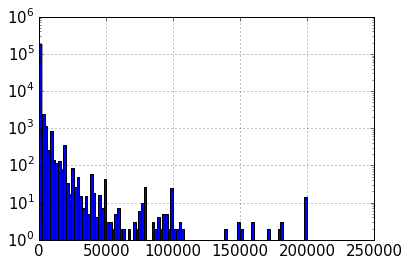

In [15]:
plt.rcParams.update({'font.size': 15})
fig = df['njobs'].hist(bins=100, log=True)

## Events per task

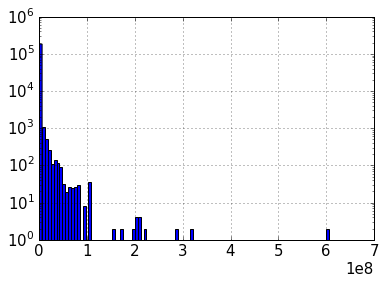

In [16]:
fig = df['jevts'].hist(bins=100, log=True)

## Plot distribution of averages of CPU time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average CPU time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average CPU time per event.

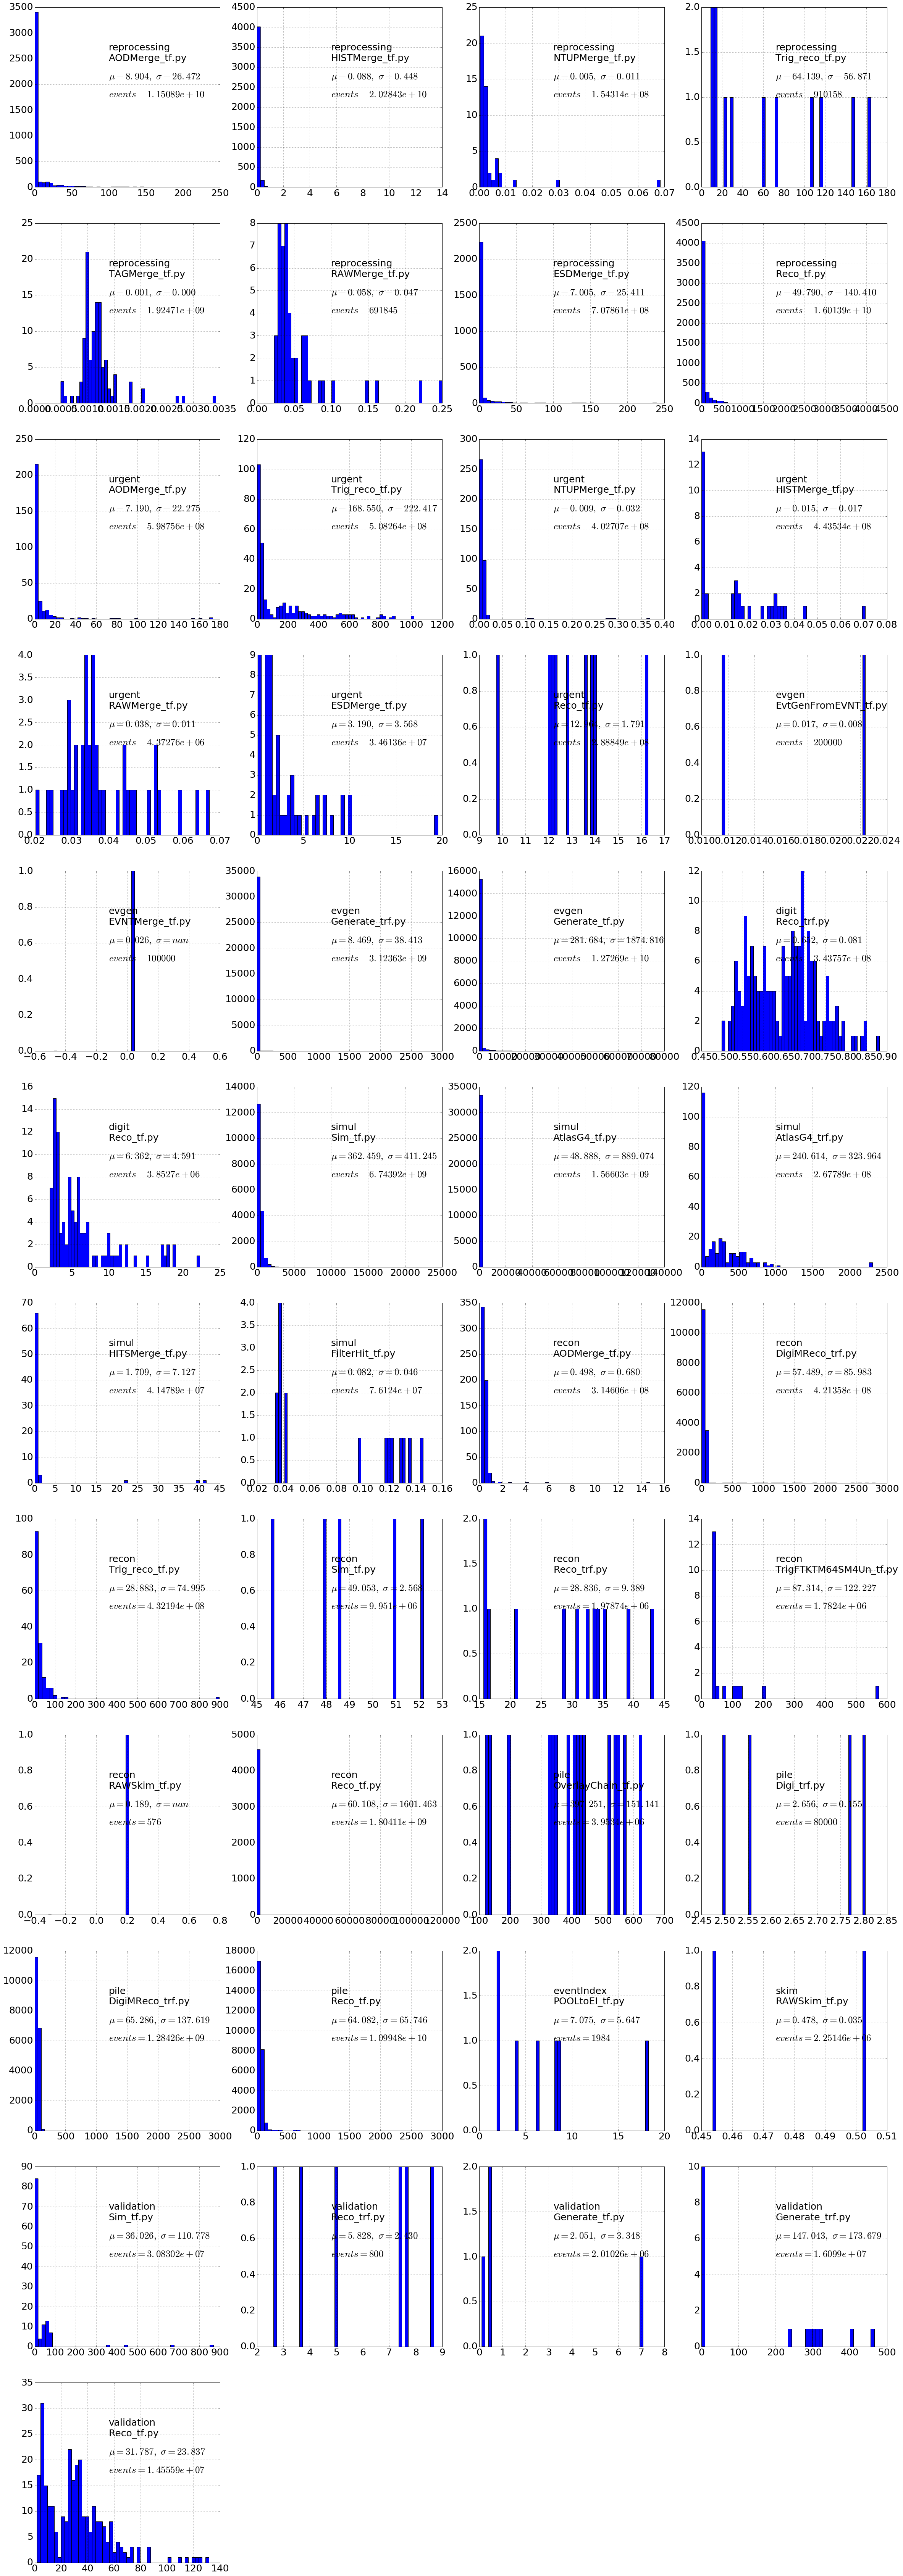

In [17]:
fig = plt.figure(figsize=(40,120))
plt.rcParams.update({'font.size': 25})
i = 1
for p in set(df['processingtype']):
    trans = set(df[df['processingtype'] == p]['transformation'])
    for t in trans:
        cpuevt = df[(df['processingtype'] == p) & (df['transformation'] == t)][['cpuevt_avg', 'cpuevt_rms', 'jevts']]
        sp = plt.subplot(12, 4, i)
        mean = cpuevt['cpuevt_avg'].mean()
        std = cpuevt['cpuevt_avg'].std()
        jevts = cpuevt['jevts'].sum()
        cpuevt['cpuevt_avg'].hist(bins=50)
        xrange = sp.get_xlim()
        yrange = sp.get_ylim()
        a_x = xrange[0] + (xrange[1]-xrange[0])*.4
        a_y1 = yrange[0] + (yrange[1]-yrange[0])*.7
        a_y2 = yrange[0] + (yrange[1]-yrange[0])*.6
        a_y3 = yrange[0] + (yrange[1]-yrange[0])*.5
        plt.text(a_x, a_y1, p+'\n'+t)
        stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
        plt.text(a_x, a_y2, stats)
        stats = r'$\mathit{events}=%g$' % jevts
        plt.text(a_x, a_y3, stats)
        i += 1

## Plot distribution of averages of wallclock time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average wallclock time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average wallclock time per event.

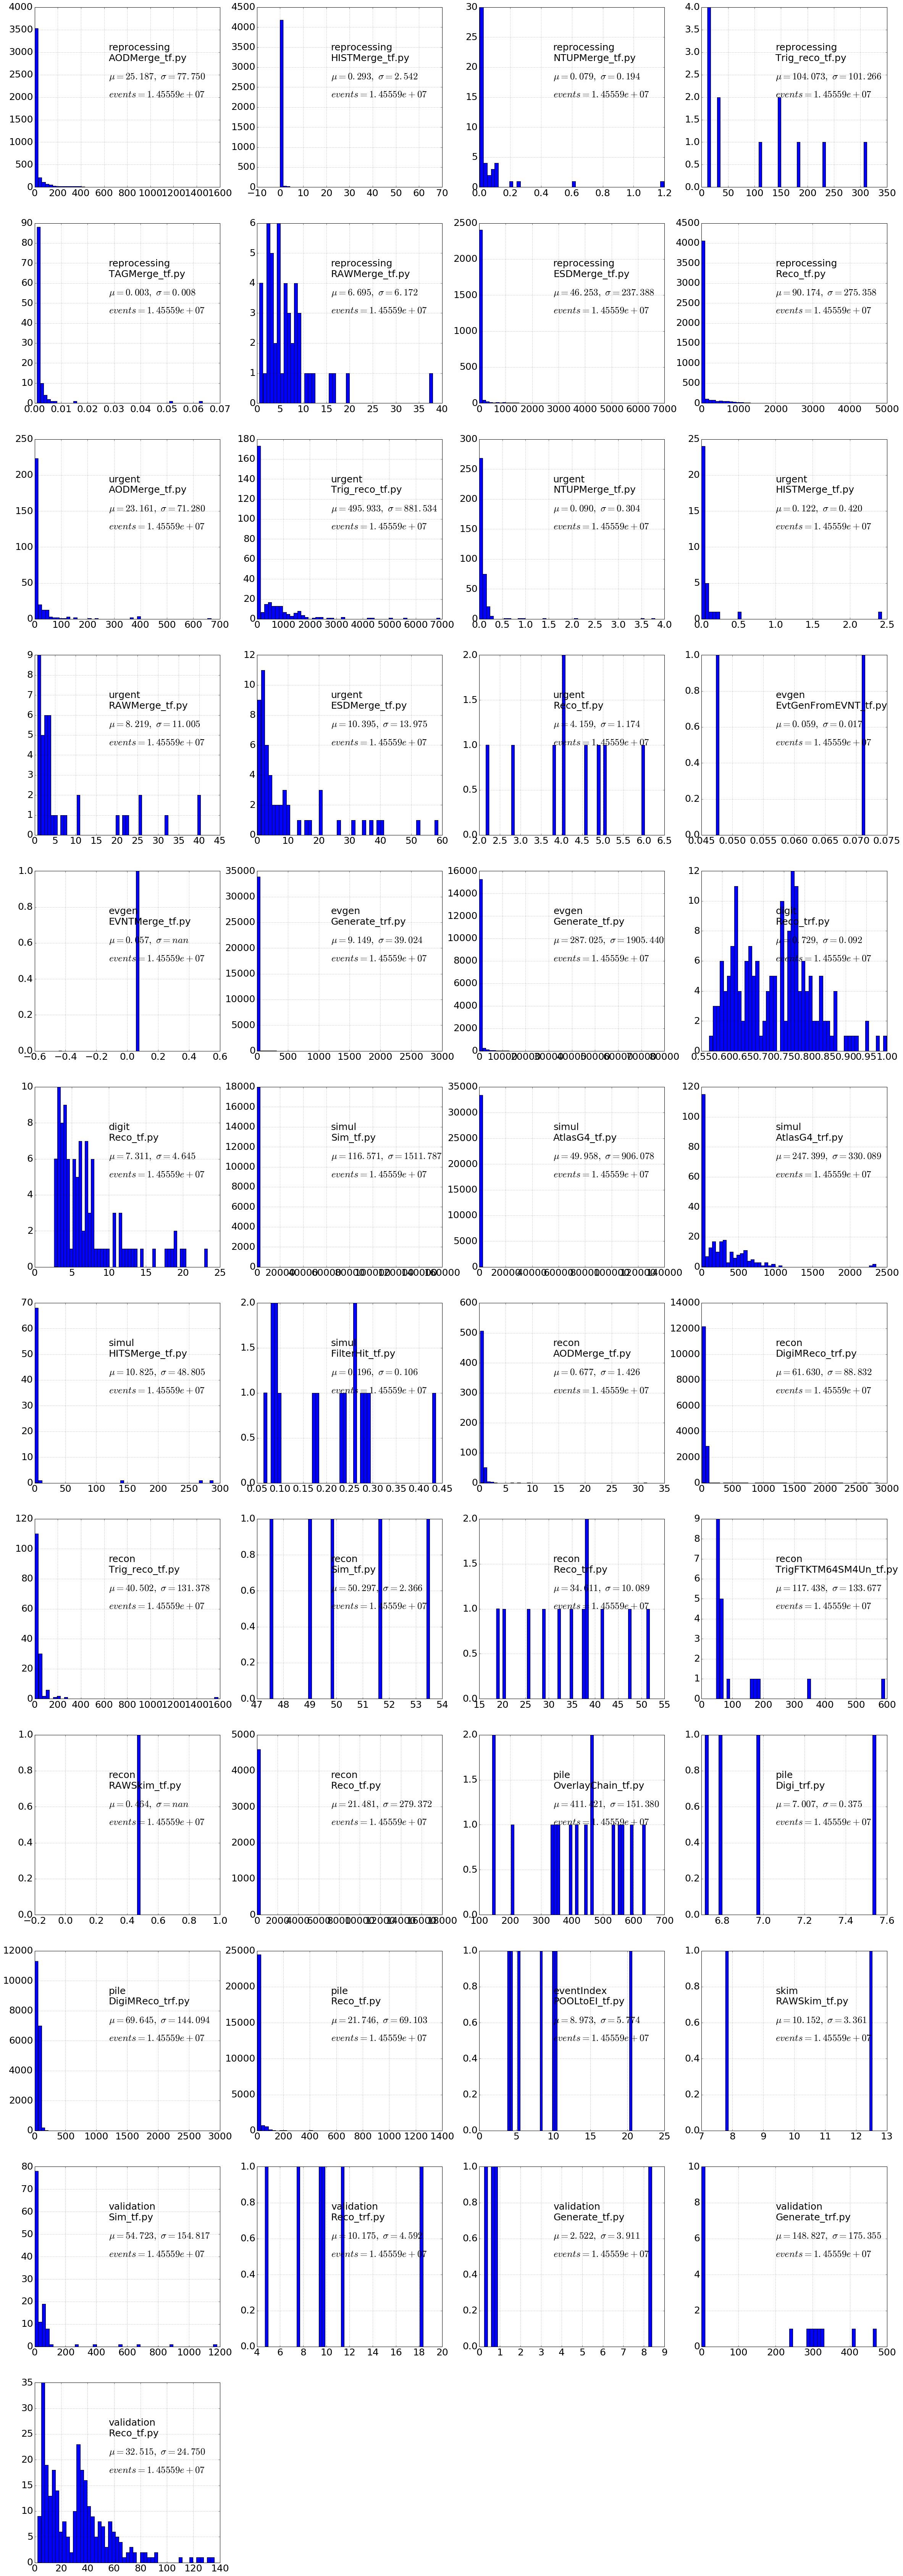

In [25]:
fig = plt.figure(figsize=(40,120))
plt.rcParams.update({'font.size': 25})
i = 1
for p in set(df['processingtype']):
    trans = set(df[df['processingtype'] == p]['transformation'])
    for t in trans:
        wcevt = df[(df['processingtype'] == p) & (df['transformation'] == t)][['wallevt_avg', 'wallevt_rms', 'jevts']]
        sp = plt.subplot(12, 4, i)
        mean = wcevt['wallevt_avg'].mean()
        std = wcevt['wallevt_avg'].std()
        jevts = cpuevt['jevts'].sum()
        wcevt['wallevt_avg'].hist(bins=50)
        xrange = sp.get_xlim()
        yrange = sp.get_ylim()
        a_x = xrange[0] + (xrange[1]-xrange[0])*.4
        a_y1 = yrange[0] + (yrange[1]-yrange[0])*.7
        a_y2 = yrange[0] + (yrange[1]-yrange[0])*.6
        a_y3 = yrange[0] + (yrange[1]-yrange[0])*.5
        plt.text(a_x, a_y1, p+'\n'+t)
        stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
        plt.text(a_x, a_y2, stats)
        stats = r'$\mathit{events}=%g$' % jevts
        plt.text(a_x, a_y3, stats)
        i += 1